# PixelCNN

### Mise en place 

In [1]:
import torch
from torch import nn, optim
from torch.functional import F
from torch.utils.data import DataLoader, TensorDataset, Subset
from tqdm.notebook import tqdm
import matplotlib.pyplot  as plt

Téléchargement des données d'entrainement si nécessaire.

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Lambda

# binarize = Lambda(lambda x: (x > 0.5).float())
# transform = Compose([ToTensor(), binarize])
transform = ToTensor()

train_data = datasets.MNIST(".",download=True,train=True, transform=transform)
test_data  = datasets.MNIST(".",download=True,train=False, transform=transform)

Sélection CPU/GPU et déclaration des loaders appropriés

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs, labels = map(list, zip(*train_data))
inputs = torch.stack(inputs).to(device)
labels = torch.tensor(labels, dtype=torch.uint8).to(device)

train = TensorDataset(inputs, labels)


inputs, labels = map(list, zip(*test_data))
inputs = torch.stack(inputs).to(device)
labels = torch.tensor(labels, dtype=torch.uint8).to(device)

test = TensorDataset(inputs, labels)

## Modèle

In [4]:
class OccludedConv2d(torch.nn.Conv2d):
    def __init__(self, *args, include_center=False, **kwargs):
        super().__init__(*args, **kwargs)

        w,h = self.weight.size()[-2:]
        mask = torch.zeros(w*h)
        mask[:w * h // 2 + int(include_center)] = 1
        mask = mask.view(w, h)

        self.register_buffer('mask', mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)


class Model(nn.Module):
    def __init__(self, input_channels=1, n_filters=64, kernel_size=7, n_layers=7):
        super().__init__()
        # The first layer uses mask type 'A'
        self.input_conv = OccludedConv2d(input_channels, n_filters, kernel_size, include_center=False, padding=kernel_size//2)

        self.hidden_convs = nn.ModuleList([
            OccludedConv2d(n_filters, n_filters, kernel_size, include_center=True, padding=kernel_size//2)
            for _ in range(n_layers)
        ])

        self.output_conv = nn.Conv2d(n_filters, input_channels, kernel_size=1)
        
    def forward(self, x):
        x = F.relu(self.input_conv(x))
        for conv in self.hidden_convs:
            x = F.relu(conv(x))
        x = self.output_conv(x)
        return x

## Infrastructure

In [5]:
from torch.distributions.beta import Beta

def generate_image(model, device, image_size=28, k=50.0):
    model.eval()
    # Start with an image filled with zeros.
    x = torch.zeros((1, 1, image_size, image_size)).to(device)
    with torch.no_grad():
        for i in range(image_size):
            for j in range(image_size):
                # Get the model's output (logits) for the current pixel
                out = model(x)
                # Use sigmoid to convert logits into probabilities
                prob = torch.sigmoid(out[0, 0, i, j])
                # Sample from the Bernoulli distribution
                x[0, 0, i, j] = Beta(prob*k, (1-prob)*k).sample()
    return x.cpu().numpy()[0, 0]

def plot_image(arr):
    plt.imshow(arr, cmap='gray')
    plt.title("Generated Digit")
    plt.show()

In [6]:
def trainer(dataset, model, optimizer, compute_loss, epochs=10, start_epoch=0, rate=1e-4, status=None):

    progress = tqdm(total=len(dataset)*epochs)
    for e in range(start_epoch, start_epoch+epochs):
        for input, _ in dataset:
            model.train()
            optimizer.zero_grad()

            output = model(input)
            loss = compute_loss(output, input)
            loss.backward()
            optimizer.step()

            progress.update()
            if status and status.should_update(e):
                status.update(e, model)

# Entrainement

In [84]:
model = Model().to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
compute_loss = nn.BCEWithLogitsLoss()

# All the digits "8" 
specific_train = [ 
    Subset(train, [i for i, l in enumerate(train) if l[1] == d])
    for d in range(10)
]

dataset = DataLoader(train_8, batch_size=16, shuffle=True)
trainer(dataset, model, optimizer,  compute_loss, epochs=200)

  0%|          | 0/73200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model = Model().to(device)
states = torch.load("models/only_0.pth", map_location=device)



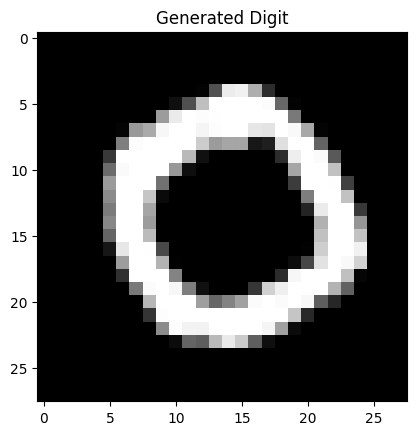

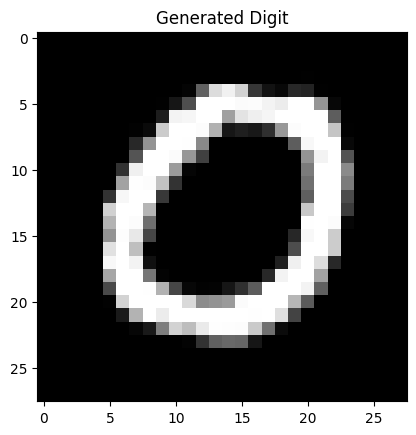

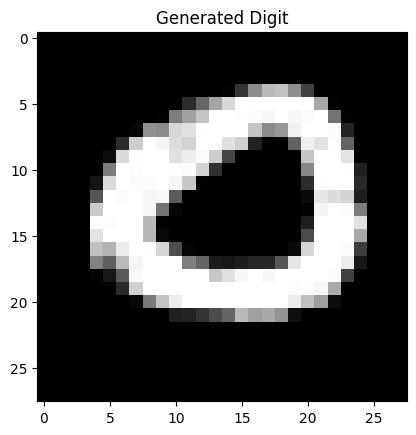

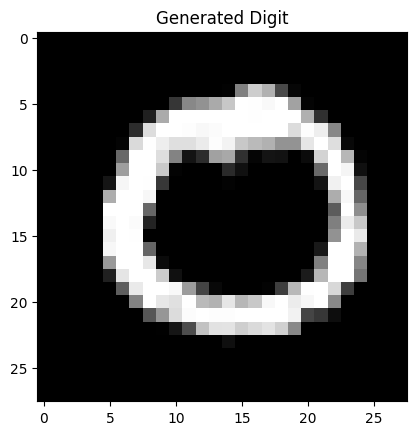

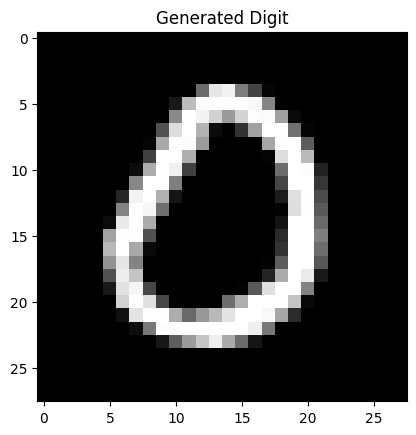

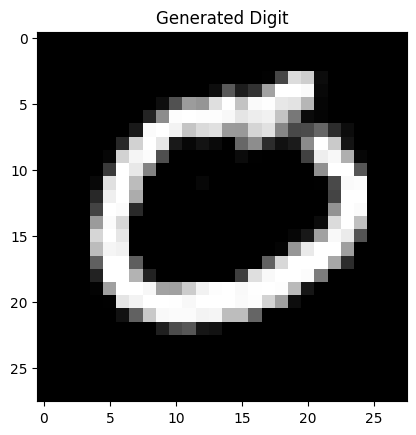

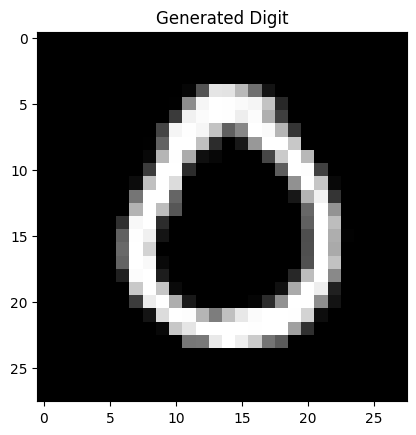

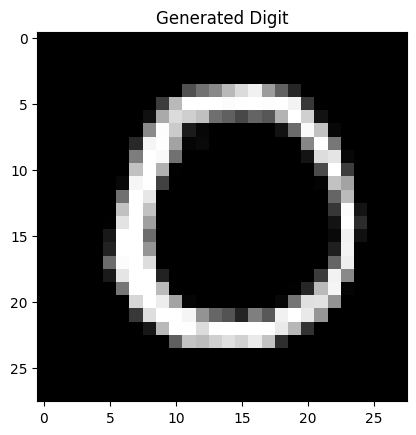

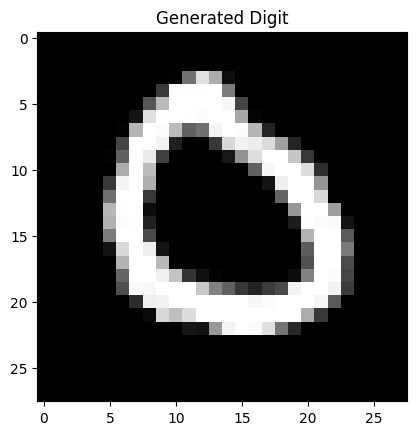

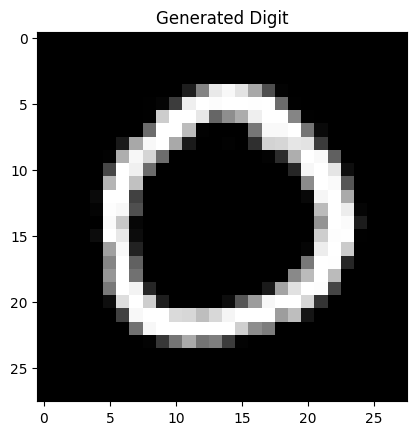

In [25]:
for _ in range(10):
    plot_image(generate_image(model, device, k=10))